In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sb
import pickle

In [2]:
def Gaussian_pdf(mu, sigma, stds=4):
    x = np.linspace(mu - stds*sigma, mu + stds*sigma, 100)
    y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    return x, y

In [3]:
def truncated_Gaussian_moments(mu, var, a=0):
    sigma = np.sqrt(var)
    alpha = (a - mu) / sigma
    phi_alpha = norm.pdf(alpha)
    Phi_alpha = norm.cdf(alpha)

    new_mean = mu + (phi_alpha / (1 - Phi_alpha)) * sigma
    new_var = var * (1 - (alpha * phi_alpha / (1 - Phi_alpha)) - ((phi_alpha / (1 - Phi_alpha))**2))

    return new_mean, new_var

In [4]:
def get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac=.9):
    A = 1/np.sqrt(1 + (tau_m*omega)**2)
    T = (2*np.pi)/omega
    expon = np.exp(-T/tau_m)
    frac_denom = (1 - expon)*R_m*I_osc*A
    
    I_min = (V_th/frac_denom - 1)*I_osc*A
    I_max = (V_th/frac_denom + 1)*I_osc*A
    
    corr_frac = (1 - range_frac) * (I_max - I_min) / 2
    I_min += corr_frac
    I_max -= corr_frac
    
    return I_min, I_max

In [5]:
def get_snr_corr_factor(tau_m, f):
    delta_Is = (1 - np.exp(-1/tau_m)) / (1 - np.exp(-1/(f*tau_m)))
    delta_Iosc = np.sqrt(1 + (tau_m*2*np.pi*f)**2) / np.sqrt(1 + (tau_m*2*np.pi)**2)
    snr = np.sqrt( delta_Is**2 + delta_Iosc**2)
    
    '''
    # noise std adjusted proportionally to (delta_Is+delta_Iosc)/(ref_Is+ref_Iosc)
    # this is justified is we assume that Var[u_free] \propto sqrt(sum(w**2)), so that effective input currents are higher
    # due to higher synaptic efficacies during Poisson-based bombardement (and not based on the firing rates).
    new_Is, new_Iosc = get_avg_Is(V_th, R_m, tau_m, f), compute_Iosc(v_osc_amp, R_m, tau_m, 2*np.pi*f)
    ref_Is, ref_Iosc = get_avg_Is(V_th, R_m, tau_m, 1), compute_Iosc(v_osc_amp, R_m, tau_m, 2*np.pi*1)
    snr = np.sqrt( (new_Is**2 + new_Iosc**2) / (ref_Is**2 + ref_Iosc**2) )
    '''
    return snr

def get_snr_corr_factor_v2(I_s):
    return I_s/I_s_ref

In [6]:
def get_avg_Is(V_th, R_m, tau_m, f):
    Is_bar = V_th / ( R_m * (1 - np.exp(-1/(f*tau_m))) )
    return Is_bar

In [7]:
def compute_Iosc(v_osc_amp, R_m, tau_m, omega):
    I_osc = abs(v_osc_amp) * np.sqrt((tau_m*omega)**2 + 1) / R_m
    return I_osc

In [8]:
def eta_to_sigma_w(eta, V_th, tau_m, f):
    snr = get_snr_corr_factor(tau_m, f)
    return (eta * snr * V_th) / np.sqrt(tau_m)

def sigma_w_to_eta(sigma_w, V_th, tau_m, f):
    snr = get_snr_corr_factor(tau_m, f)
    return (sigma_w * np.sqrt(tau_m)) / (V_th * snr)

In [15]:
def compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc):
    A = 1/np.sqrt(1 + (tau_m*omega)**2)
    ph = -np.arctan(tau_m*omega) - np.pi
    m = I_s/(A*I_osc)
    T = (2*np.pi)/omega
    b = V_th/(R_m*I_osc*A*(1 - np.exp(-T/tau_m)))
    phi = np.nan_to_num(-np.arccos(b - m) - ph)
    return phi

def compute_var_phi(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, N):
    phi_i = compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc)
    #snr = get_snr_corr_factor(tau_m, f)
    snr = get_snr_corr_factor_v2(I_s)
    numerator = omega**2 * eta**2 * snr**2 * V_th**2 * (1 - np.exp(-2/(f*tau_m))) * tau_m**2
    denominator = 2 * N * (-V_th + R_m * I_s - R_m * I_osc * np.cos(phi_i))**2
    var =  numerator/denominator
    return var

def get_distr(R_m, V_th, eta, tau_m, v_osc_amp, f, M, range_frac, N):
    omega = 2 * np.pi * f
    #I_osc = compute_Iosc(v_osc_amp, R_m, tau_m, omega)
    I_min, I_max = get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac)
    Is_range = np.linspace(I_min, I_max, M)
    means = [compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc) for I_s in Is_range]
    variances = [compute_var_phi(R_m, V_th, eta, tau_m, omega, I_s, I_osc, f, N) for I_s in Is_range]
    return np.array(means), np.array(variances), Is_range

In [16]:
# Params
N = 1                  # number of neurons
R_m = 142 * 1e6        # MOmh
V_th = 15 * 1e-3       # mV
tau_m = 24 * 1e-3      # ms
f = 5                  # Hz
omega = 2 * np.pi * f  # Hz
v_osc_amp = 5 * 1e-3   # mV
#I_osc = compute_Iosc(v_osc_amp, R_m, tau_m, f)
I_osc = 40 * 1e-12     # pA
M = 5                  # number input levels
range_frac = 0.75
#eta = 0.14             # a.u  //  sigma_w = 0.012-0.015 V/sqrt(s), acoording to Lansky et al (2006). eta=0.124-0.155 a.u.
eta = sigma_w_to_eta((0.012+0.015)/2, V_th, tau_m, f)

#I_min, I_max = get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac)
#Is_range = np.linspace(I_min, I_max, M)

#phis_0 = list(map(lambda I_s : compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc), Is_range))

In [17]:
#I_osc_ref = compute_Iosc(v_osc_amp, R_m, tau_m, 2*np.pi*1)
I_s_ref, _ = get_automatic_range(R_m, V_th, tau_m, 2*np.pi*1, I_osc, range_frac)

In [18]:
means, variances, Is_range = get_distr(R_m, V_th, eta, tau_m, v_osc_amp, f, M, range_frac, N)

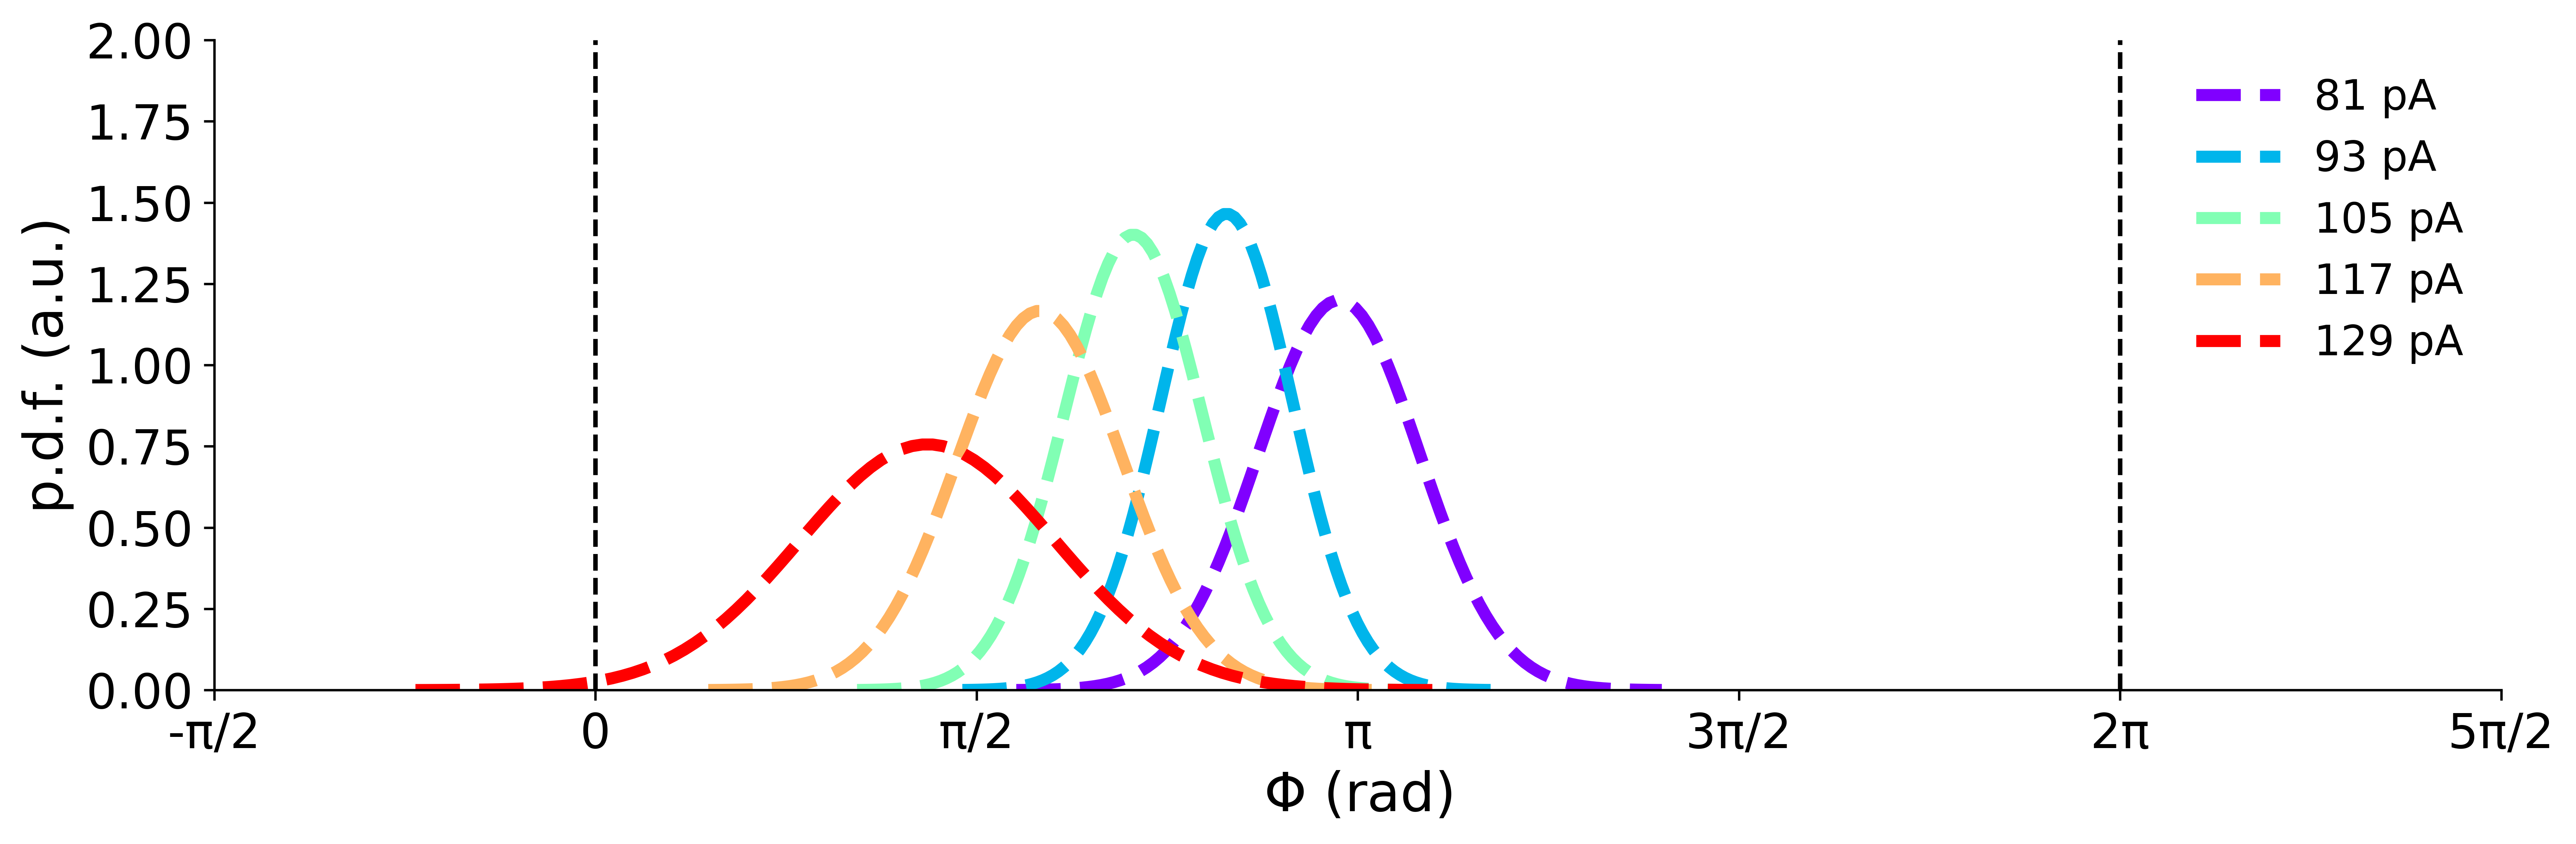

In [19]:
plt.figure(figsize=(12,4), dpi=600)

alphas = np.linspace(0.2, 1, M)
c = cm.rainbow(np.linspace(0, 1, M))

for i, Is in enumerate(Is_range):
    x, y = Gaussian_pdf(means[i], np.sqrt(variances[i]))
    plt.plot(x, y, linewidth=4, linestyle='--', color=c[i], label=str(int(Is*1e12))+" pA")

plt.legend(frameon=False, fontsize=14)
plt.ylabel('p.d.f. (a.u.)', fontsize=18)
plt.xlabel('$\mathit{\Phi}$ (rad)', fontsize=18)
plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=16)
plt.xlim(-np.pi/2, (5/2)*np.pi)
plt.ylim(0, 2)
plt.yticks(fontsize=16)

plt.axvline(0, linestyle='--', color='k')
plt.axvline(2*np.pi, linestyle='--', color='k')

sb.despine()
plt.tight_layout()
#plt.savefig('distr.png', dpi=600)
plt.show()

In [20]:
fs_grid = [1, 5, 30, 100]
etas_grid = [0.05, 0.1, 0.2, 0.4]
#sigmas_w = eta_to_sigma_w(np.array(etas_grid), V_th, tau_m, f)
alphas = np.linspace(0.2, 1, M)
c = cm.rainbow(np.linspace(0, 1, M))

plt.figure(figsize=(15,15), dpi=600)
count = 1
for i, eta in enumerate(etas_grid):
    for j, f in enumerate(fs_grid):
        means, variances, Is_range = get_distr(R_m, V_th, eta, tau_m, v_osc_amp, f, M, range_frac, N)
        #means, variances = truncated_Gaussian_moments(means, variances, a=0)
        
        plt.subplot(4,4,count)
        for k, Is in enumerate(Is_range):
            x, y = Gaussian_pdf(means[k], np.sqrt(variances[k]))
            plt.plot(x, y, linewidth=2, linestyle='--', color=c[k], label=str(int(Is*1e12))+" pA")
        
        plt.title(r"$\eta = $" + str(eta) + r", $f = $" + str(f))
        plt.legend(frameon=False, fontsize=8)
        plt.xlabel('$\mathit{\Phi}$ (rad)', fontsize=14)
        plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=14)
        #plt.xlim(-np.pi/2, (5/2)*np.pi)
        plt.xlim(0, 2*np.pi)
        plt.ylim(0, 4)
        plt.yticks(fontsize=14)
        sb.despine()
        count+=1
        
plt.tight_layout()

#plt.savefig('plots/phase_distr_theo.png', dpi=600)

plt.show()

## Info rate

In [21]:
def approx_mi(means, variances):
    return np.log(np.mean(variances) + np.var(means)) - np.mean(np.log(variances))

def numerical_mi(means, variances, n_samples=int(1e4)):
    samples = []
    for mean, var in zip(means, variances):
        samples.extend(norm.rvs(loc=mean, scale=np.sqrt(var), size=n_samples))
    histogram, _ = np.histogram(samples, bins='auto', density=True)
    histogram = histogram + np.finfo(float).eps
    H_Y = -np.sum(histogram * np.log(histogram) * np.diff(np.linspace(np.min(samples), np.max(samples), len(histogram) + 1)))

    H_Y_given_X = np.mean([0.5 * np.log(2 * np.pi * np.e * var) for var in variances])

    return H_Y - H_Y_given_X

def get_R(mis, fs, tau_x, corr=True, norm=True):
    info_rate = mis * fs[np.newaxis, :]
    
    if corr:
        corr_fact_sampling = (1 - np.exp(-(1/(fs*tau_x))))
        info_rate = info_rate * corr_fact_sampling[np.newaxis, :]
    
    if norm:
        info_rate_norm = np.zeros_like(info_rate)  
        for index, row in enumerate(info_rate):
            info_rate_norm[index, :] = row/np.max(row)
        info_rate = info_rate_norm
        
    return info_rate

In [22]:
M = 10
res = 1000
fs = np.linspace(1, 100, res)
etas = np.linspace(0.001, 0.4, res)
mis_approx = np.zeros((res,res))
mis_numerical = np.zeros((res,res))
for i, eta in enumerate(etas):
    print(i)
    for j, f in enumerate(fs):
        means, variances, Is_range = get_distr(R_m, V_th, eta, tau_m, v_osc_amp, f, M, range_frac, N)
        #means, variances = truncated_Gaussian_moments(means, variances, a=0)
        mis_approx[i, j] = approx_mi(means, variances)
        #mis_numerical[i, j] = numerical_mi(means, variances, n_samples=int(2e4))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

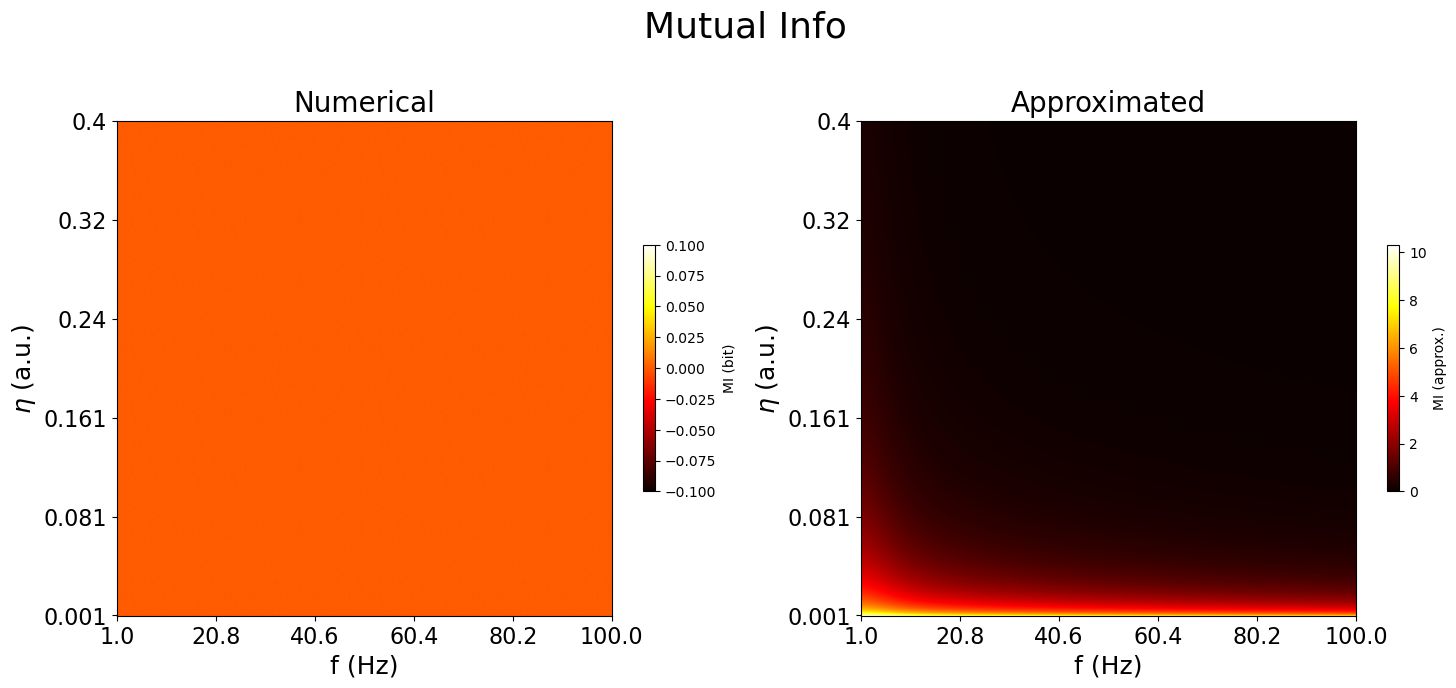

In [31]:
plt.figure(figsize=(15,7))

plt.suptitle("Mutual Info", fontsize=26)

plt.subplot(121)
plt.title('Numerical', fontsize=20)
plt.imshow(mis_numerical, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).round(1), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.001, 0.4, 6).round(3), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='MI (bit)', shrink=.4)


plt.subplot(122)
plt.title('Approximated', fontsize=20)
plt.imshow(mis_approx, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).round(1), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.001, 0.4, 6).round(3), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='MI (approx.)', shrink=.4)


plt.tight_layout()
plt.show()

In [24]:
#np.save('results/mis_approx_theo.npy', mis_approx)
#np.save('results/mis_numerical_theo.npy', mis_numerical)

In [64]:
tau_x = 100e-3
res = 1000
fs = np.linspace(1, 100, res)
info_rate_approx_norm = get_R(mis_approx, fs, tau_x=tau_x, corr=True, norm=True)
info_rate_numerical_norm = get_R(mis_numerical, fs, tau_x=tau_x, corr=True, norm=True)

C:\Users\Afernandez\AppData\Local\Temp\ipykernel_43340\390471527.py:26: RuntimeWarning: invalid value encountered in divide
  info_rate_norm[index, :] = row/np.max(row)


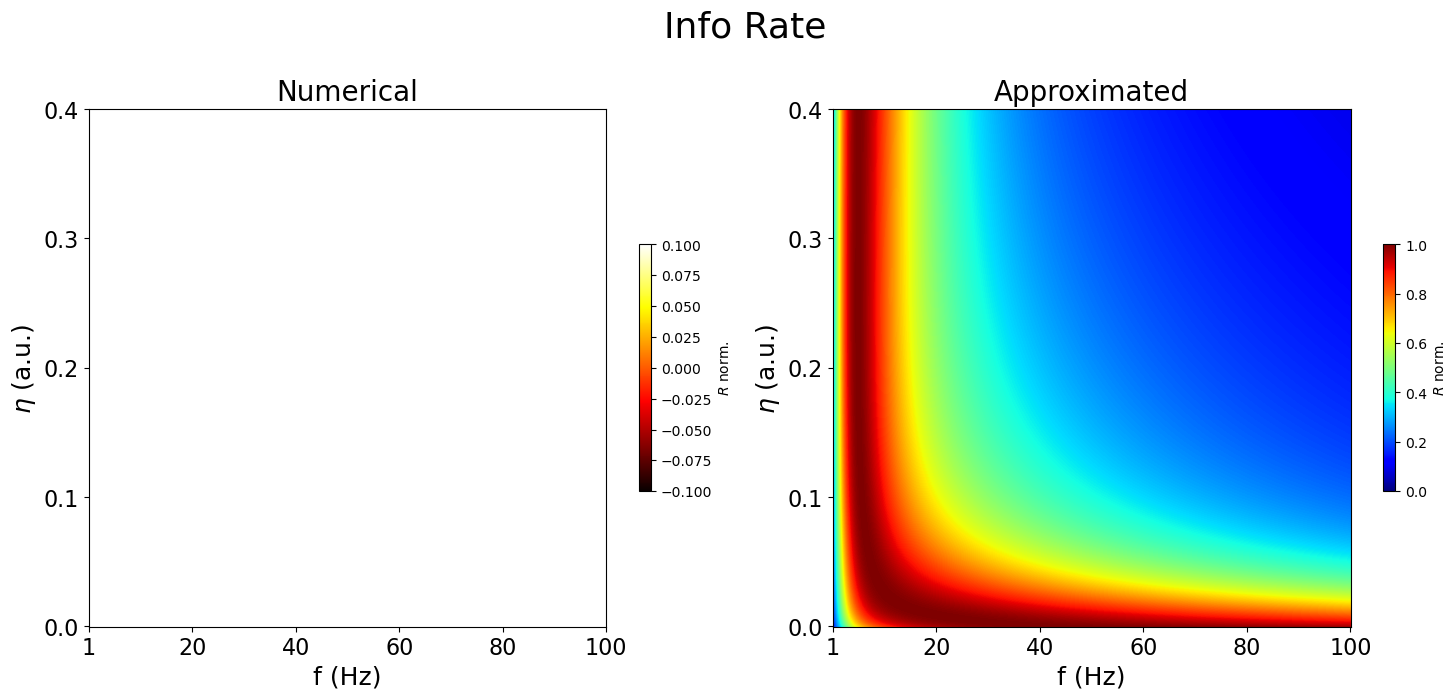

In [65]:
plt.figure(figsize=(15,7))

plt.suptitle("Info Rate", fontsize=26)

plt.subplot(121)
plt.title('Numerical', fontsize=20)
plt.imshow(info_rate_numerical_norm, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).astype(int), fontsize=16)
plt.yticks(np.linspace(0, res-1, 5), np.linspace(0.001, 0.4, 5).round(2), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='$R$ norm.', shrink=.4)


plt.subplot(122)
plt.title('Approximated', fontsize=20)
plt.imshow(info_rate_approx_norm, origin='lower', cmap='jet', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).astype(int), fontsize=16)
plt.yticks(np.linspace(0, res-1, 5), np.linspace(0.001, 0.4, 5).round(2), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='$R$ norm.', shrink=.4)


plt.tight_layout()
#plt.savefig('plots/info_rate_approx.png', dpi=600)
plt.show()

In [29]:
optimal_fs_ = []
tau_x_range = np.array([200, 100, 50, 25])*1e-3
for tau_x_ in tau_x_range:
    info_rate_approx_norm_ = get_R(mis_approx, fs, tau_x_, norm=True)
    optimal_fs_.append(fs[np.argmax(info_rate_approx_norm_, axis=1)])

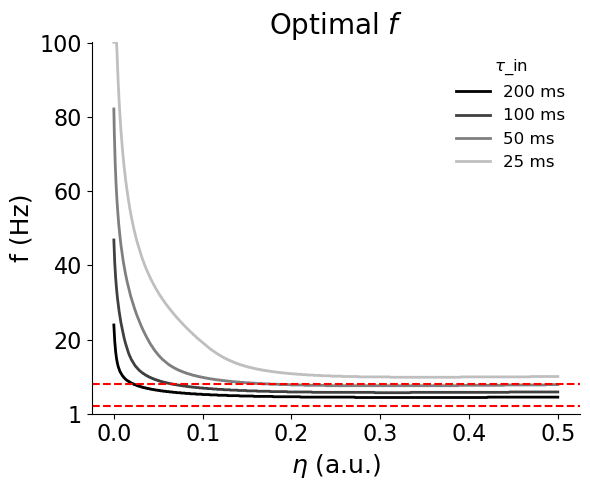

In [30]:
plt.figure(figsize=(6,5))

plt.title('Optimal $f$', fontsize=20)

for i, tau_x_ in enumerate(tau_x_range):
    plt.plot(optimal_fs_[i]*(res/100), linewidth=2, color='k', alpha=1-(2.5*i/10), label=str(int(tau_x_*1e3))+' ms')

plt.yticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).astype(int), fontsize=16)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(0.0001, 0.5, 6).round(3), fontsize=16)
plt.ylabel('f (Hz)', fontsize=18)
plt.xlabel('$\eta$ (a.u.)', fontsize=18)

plt.axhline(2*(res/100), color='r', linestyle='--')
plt.axhline(8*(res/100), color='r', linestyle='--')

plt.ylim(0,res)

plt.legend(title='$τ$_in', fontsize=12, title_fontsize='large', frameon=False)

plt.tight_layout()
sb.despine()
plt.savefig('plots/optimal_f.png', dpi=600)
plt.show()

## Simulation

In [42]:
def simulate_neurons(R_m, V_th, eta, tau_m, omega, I_s, v_osc_amp, f, M, dt, t, n_neurons):
    I_osc = compute_Iosc(v_osc_amp, R_m, tau_m, omega)
    #snr = get_snr_corr_factor(tau_m, f)
    snr = get_snr_corr_factor_v2(I_s)
    sigma_W = eta * snr * V_th / np.sqrt(tau_m)
    phi_0 = compute_mean_phi(R_m, V_th, tau_m, omega, I_s, I_osc)
    #amp_AHP, tau_AHP = 500e-12, 1/f
    
    V = np.zeros(n_neurons)
    first_spike_phase = np.empty(n_neurons, dtype='object')
    first_spike_phase[:] = None
    has_spiked = np.zeros(n_neurons, dtype=bool)
    for i in range(len(t)):
        xi = np.random.normal(0, 1/np.sqrt(dt), n_neurons)
        I_theta = I_osc * np.cos(omega * t[i] - np.pi + phi_0)
        #I_AHP = amp_AHP * np.exp(-t[i]/tau_AHP)
        dV_dt = (-V + R_m * I_theta + R_m * I_s + tau_m * sigma_W * xi) / tau_m
        V += dV_dt * dt
    
        spiked = V >= V_th
        if np.any(spiked):
            V[spiked] = 0 
            if (omega * t[i] - np.pi + phi_0) > np.pi:
                mask = spiked & (first_spike_phase == None)
                first_spike_phase[mask] = (omega * t[i] + phi_0) % (2*np.pi)

                if np.all(first_spike_phase != None):
                    break
                
    return first_spike_phase

In [43]:
def get_distr_empirical(R_m, V_th, eta, tau_m, v_osc_amp, f, M, dt, t, num_trials, range_frac):
    omega = 2*np.pi*f
    #I_osc = compute_Iosc(v_osc_amp, R_m, tau_m, omega)
    I_min, I_max = get_automatic_range(R_m, V_th, tau_m, omega, I_osc, range_frac=range_frac)
    Is_range = np.linspace(I_min, I_max, M)
    
    means = []
    variances = []
    all_first_spike_phases = []
    for I_s in Is_range:
        first_spike_phases = simulate_neurons(R_m, V_th, eta, tau_m, omega, I_s, v_osc_amp, f, M, dt, t, num_trials)
        first_spike_phases = np.where(first_spike_phases == None, np.nan, first_spike_phases)
        all_first_spike_phases.append(first_spike_phases)  
        means.append( np.nanmean(first_spike_phases) )
        variances.append( np.nanvar(first_spike_phases) )
        
    return np.array(means), np.array(variances), all_first_spike_phases, Is_range

In [44]:
# Params
N = 1                  # number of neurons
f = 5.                 # Hz
eta = 0.11             # a.u.
M = 5                  # number input levels

# Simulation parameters
dt = 1e-4              # Time step for numerical integration
t_end = 2 / f          # Duration of one cycle
t = np.arange(0, t_end, dt)
num_trials = 1000      # Number of trials

In [45]:
means, variances, all_phis, Is_range = get_distr_empirical(R_m, V_th, eta, tau_m, v_osc_amp, f, M, dt, t, num_trials, range_frac)

C:\Users\Afernandez\anaconda3\lib\site-packages\numpy\lib\histograms.py:837: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Afernandez\anaconda3\lib\site-packages\numpy\lib\histograms.py:838: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


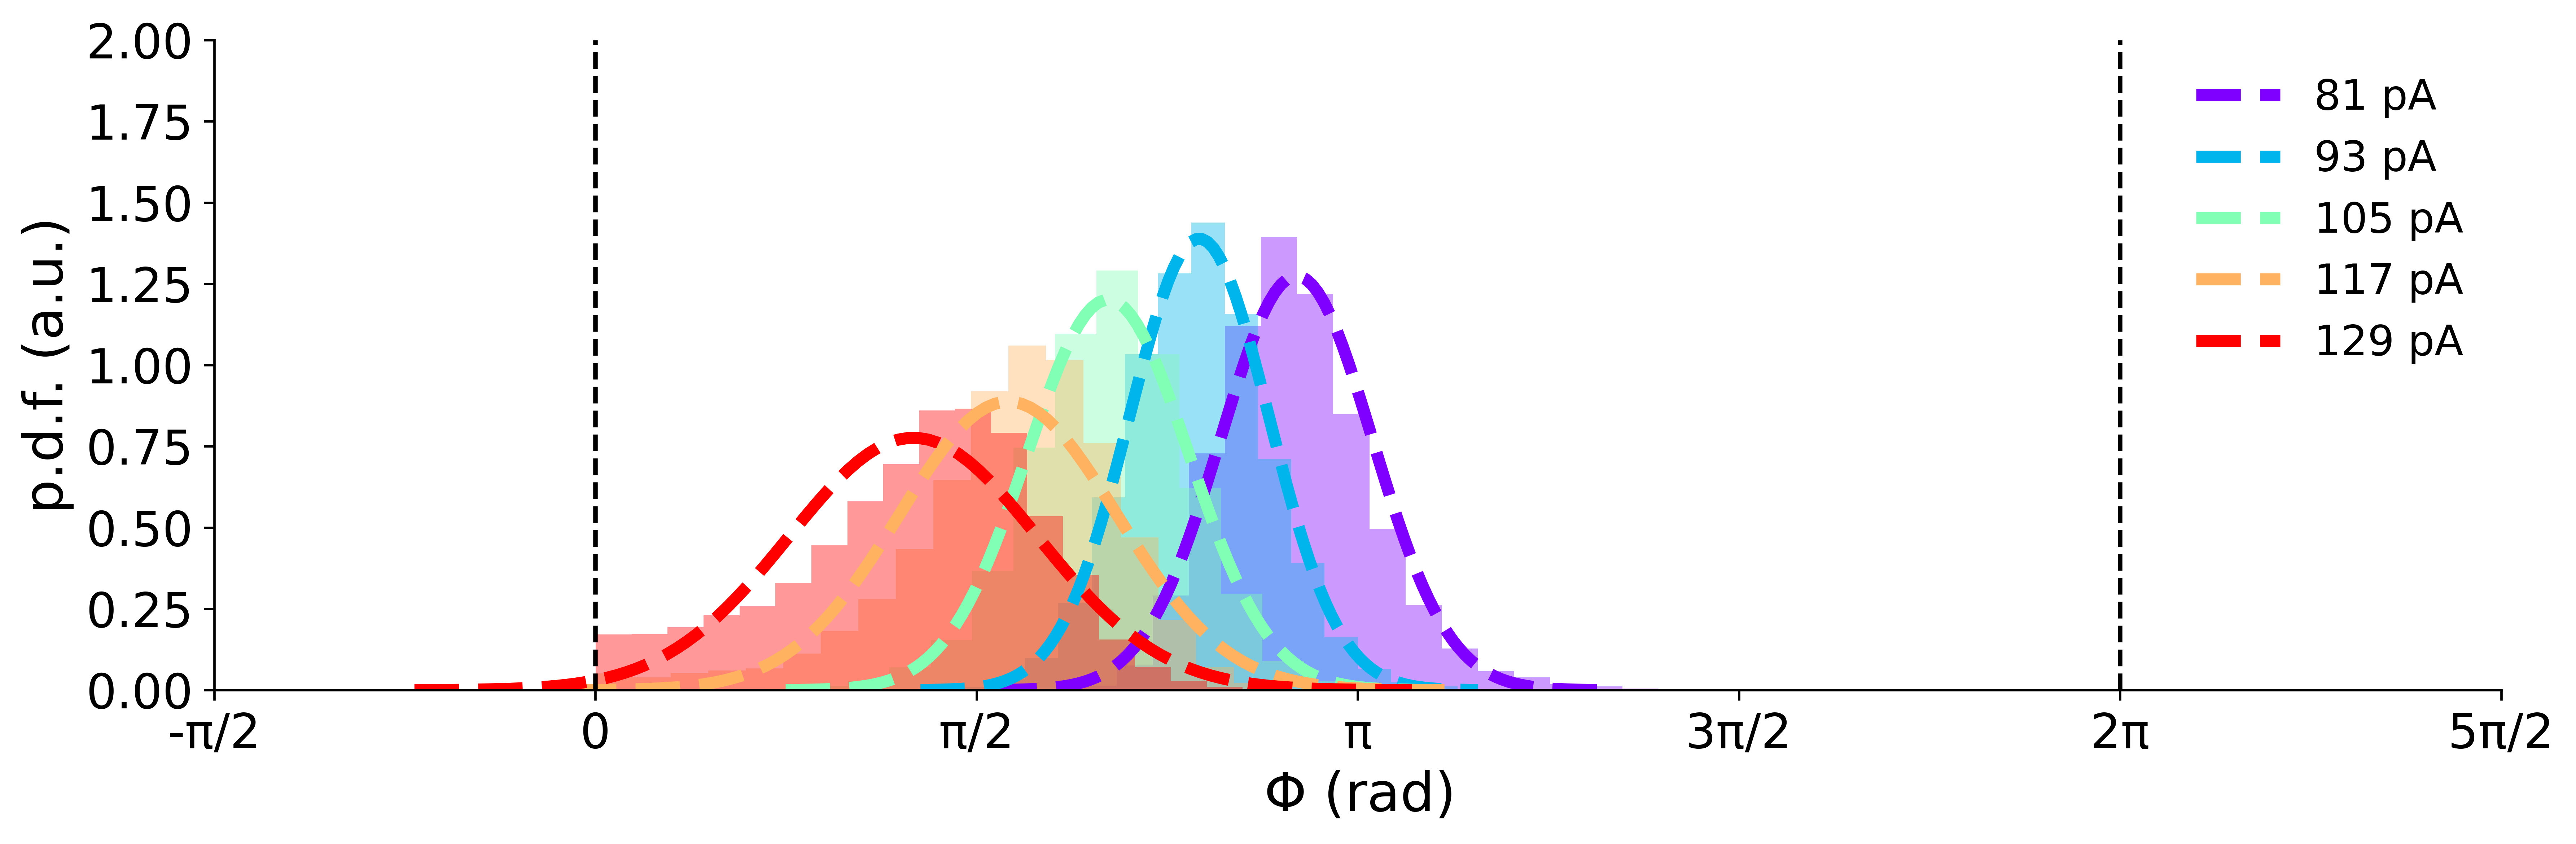

In [46]:
plt.figure(figsize=(12,4), dpi=600)

alphas = np.linspace(0.2, 1, M)
c = cm.rainbow(np.linspace(0, 1, M))

for i, Is in enumerate(Is_range):
    x, y = Gaussian_pdf(means[i], np.sqrt(variances[i]))
    plt.plot(x, y, linewidth=4, linestyle='--', color=c[i], label=str(int(Is*1e12))+" pA")
    plt.hist(all_phis[i], bins=20, density=True, color=c[i], alpha=.4)

plt.legend(frameon=False, fontsize=14)
plt.ylabel('p.d.f. (a.u.)', fontsize=18)
plt.xlabel('$\mathit{\Phi}$ (rad)', fontsize=18)
plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=16)
plt.xlim(-np.pi/2, (5/2)*np.pi)
plt.ylim(0, 2)
plt.yticks(fontsize=16)

plt.axvline(0, linestyle='--', color='k')
plt.axvline(2*np.pi, linestyle='--', color='k')

sb.despine()
plt.tight_layout()
plt.show()

In [47]:
fs_grid = [1, 5, 30, 100]
etas_grid = [0.05, 0.1, 0.2, 0.4]
alphas = np.linspace(0.2, 1, M)
c = cm.rainbow(np.linspace(0, 1, M))

plt.figure(figsize=(15,15), dpi=600)
count = 1
for i, eta in enumerate(etas_grid):
    for j, f in enumerate(fs_grid):
        t_end = 2 / f
        t = np.arange(0, t_end, dt)
        
        means, variances, all_phis, Is_range = get_distr_empirical(R_m, V_th, eta, tau_m, v_osc_amp, f, M, dt, t, num_trials, range_frac)
        
        plt.subplot(4,4,count)
        for k, Is in enumerate(Is_range):
            x, y = Gaussian_pdf(means[k], np.sqrt(variances[k]))
            plt.plot(x, y, linewidth=2, linestyle='--', color=c[k], label=str(int(Is*1e12))+" pA")
            plt.hist(all_phis[k], bins=20, density=True, color=c[k], alpha=.4)
        
        plt.title(r"$\eta = $" + str(eta) + r", $f = $" + str(f))
        plt.legend(frameon=False, fontsize=8)
        plt.xlabel('$\mathit{\Phi}$ (rad)', fontsize=14)
        plt.xticks(np.linspace(-np.pi/2, (5/2)*np.pi, 7), ['-π/2', '0', 'π/2', 'π', '3π/2', '2π', '5π/2'], fontsize=14)
        #plt.xlim(-np.pi/2, (5/2)*np.pi)
        plt.xlim(0, 2*np.pi)
        plt.ylim(0, 4)
        plt.yticks(fontsize=14)
        sb.despine()
        count+=1
plt.tight_layout()

plt.savefig('plots/phase_distr_sim.png', dpi=600)

plt.show()

#### Noise-frequency heatmap

In [42]:
# Simulation parameters
dt = 1e-4            # Time step for numerical integration
num_trials = 2000    # Number of trials
M = 10

In [ ]:
res = 200
fs = np.linspace(1, 100, res)
etas = np.linspace(0.001, 0.5, res)
mis_empirical_approx = np.zeros((res,res))
mis_empirical_numerical = np.zeros((res,res))
for i, eta in enumerate(etas):
    print(i)
    for j, f in enumerate(fs):
        t_end = 2 / f
        t = np.arange(0, t_end, dt)
        means, variances, all_phis, Is_range = get_distr_empirical(R_m, V_th, eta, tau_m, v_osc_amp, f, M, dt, t, num_trials, range_frac)
        mis_empirical_approx[i, j] = approx_mi(means, variances)
        mis_empirical_numerical[i, j] = numerical_mi(means, variances, n_samples=int(1e4))

#### Noise-frequency heatmap - Cluster data

In [57]:
# Generate and save MI heatmap based on all pickle files
res = 200
mis_empirical_numerical = np.zeros((res, res))
for idx in range(int(res**2)):
    filename = 'Data/' + 'experimental_' + '{0:03d}'.format(int(idx/res)) + '_' + '{0:03d}'.format(int(idx%res)) + ".pickle"
    with open(filename, 'rb') as handle:
        mis_empirical_numerical[int(idx/res), int(idx%res)] = pickle.load(handle)["MI"]
        
np.save('results/cluster_data_mis.npy', mis_empirical_numerical)

In [58]:
# Load data
mis_empirical_numerical = np.load('results/cluster_data_mis.npy')

NameError: name 'mis_empirical_approx' is not defined

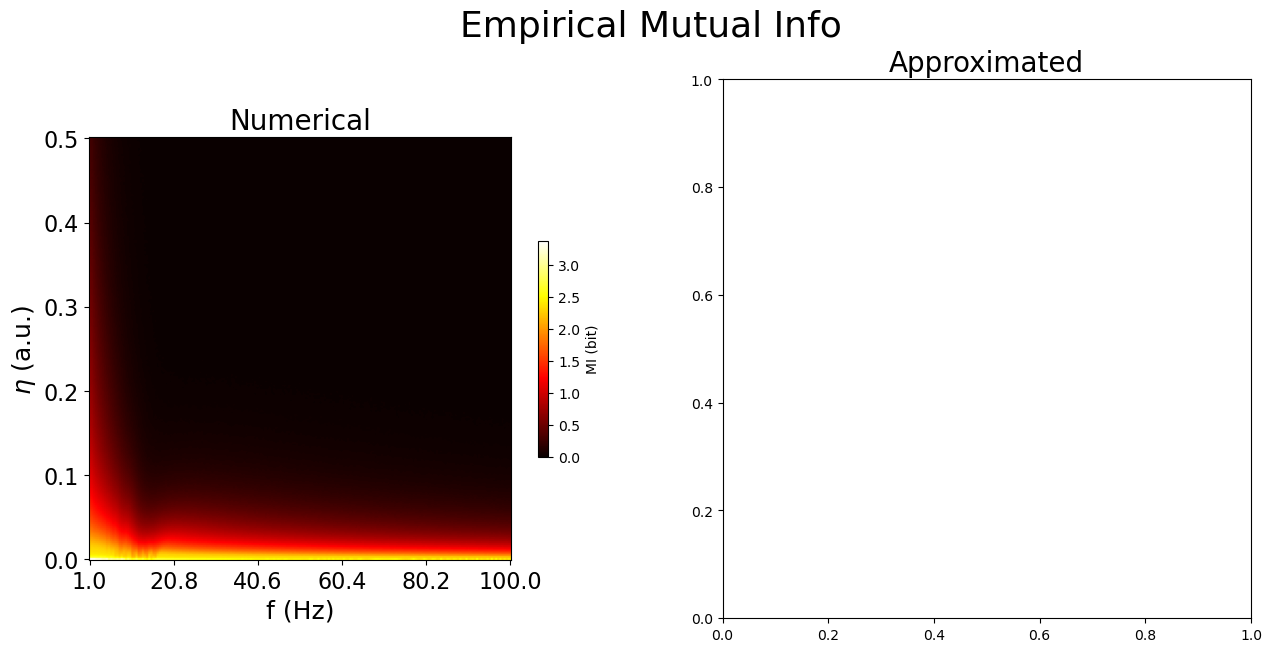

In [88]:
plt.figure(figsize=(15,7))

plt.suptitle("Empirical Mutual Info", fontsize=26)

res=200
plt.subplot(121)
plt.title('Numerical', fontsize=20)
plt.imshow(mis_empirical_numerical, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).round(1), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.0001, 0.5, 6).round(3), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='MI (bit)', shrink=.4)


plt.subplot(122)
plt.title('Approximated', fontsize=20)
plt.imshow(mis_empirical_approx, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).round(1), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.0001, 0.5, 6).round(3), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='MI (approx.)', shrink=.4)


plt.tight_layout()
plt.show()

In [61]:
tau_x = 100e-3
res = 200
fs = np.linspace(1, 100, res)
#info_rate_empirical_approx_norm = get_R(mis_empirical_approx, fs, tau_x, norm=True)
info_rate_empirical_numerical_norm = get_R(mis_empirical_numerical, fs, tau_x, norm=True)

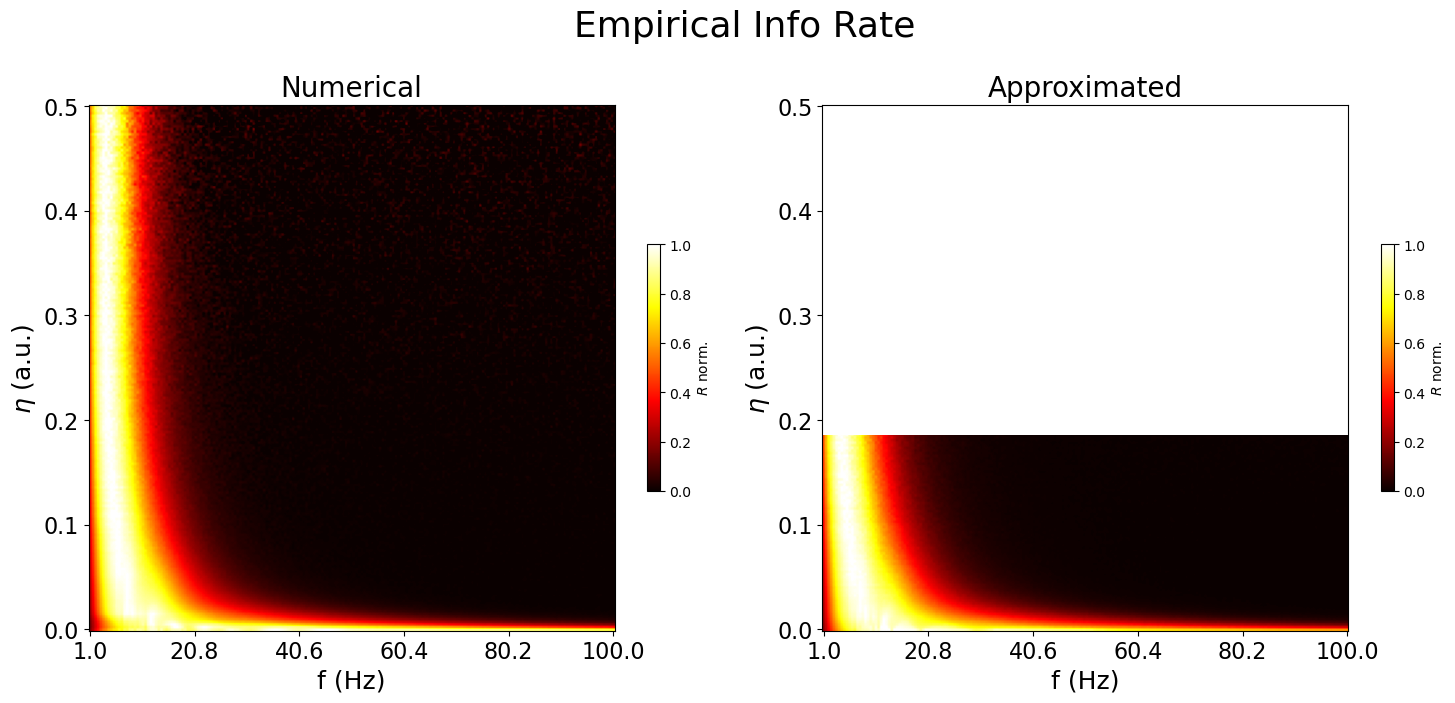

In [54]:
plt.figure(figsize=(15,7))

plt.suptitle("Empirical Info Rate", fontsize=26)

plt.subplot(121)
plt.title('Numerical', fontsize=20)
plt.imshow(info_rate_empirical_numerical_norm, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).round(1), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.0001, 0.5, 6).round(3), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='$R$ norm.', shrink=.4)


plt.subplot(122)
plt.title('Approximated', fontsize=20)
plt.imshow(info_rate_empirical_approx_norm, origin='lower', cmap='hot', vmin=0)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).round(1), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(0.0001, 0.5, 6).round(3), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='$R$ norm.', shrink=.4)


plt.tight_layout()
plt.show()

### Theory vs Simulations

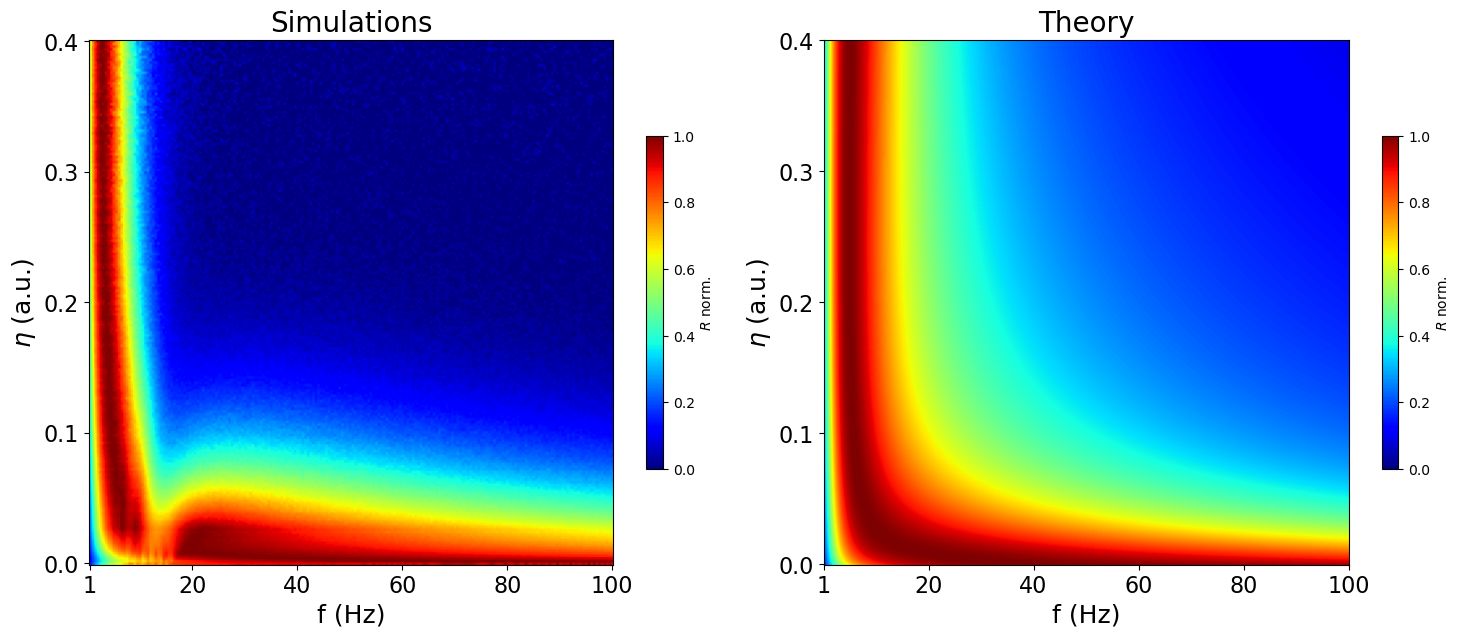

In [75]:
plt.figure(figsize=(15,7))


res = 200

plt.subplot(121)
plt.title('Simulations', fontsize=20)
plt.imshow(info_rate_empirical_numerical_norm, origin='lower', cmap='jet', vmin=0)
plt.xticks(np.linspace(0, res-1, 6).astype(int), np.linspace(1, 100, 6).astype(int), fontsize=16)
plt.yticks(np.linspace(0, res-1, 5), np.linspace(0.001, 0.4, 5).round(1), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='$R$ norm.', shrink=.5)


res = 1000

plt.subplot(122)
plt.title('Theory', fontsize=20)
plt.imshow(info_rate_approx_norm, origin='lower', cmap='jet', vmin=0)
plt.xticks(np.linspace(0, res-1, 6).astype(int), np.linspace(1, 100, 6).astype(int), fontsize=16)
plt.yticks(np.linspace(0, res-1, 5), np.linspace(0.001, 0.4, 5).round(1), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('$\eta$ (a.u.)', fontsize=18)
plt.colorbar(label='$R$ norm.', shrink=.5)


plt.tight_layout()
plt.savefig('plots/sim_vs_theo.png', dpi=600)
plt.show()

In [67]:
optimal_fs_sim = fs[np.argmax(info_rate_empirical_numerical_norm, axis=1)]
optimal_fs_theo = fs[np.argmax(info_rate_approx_norm, axis=1)]

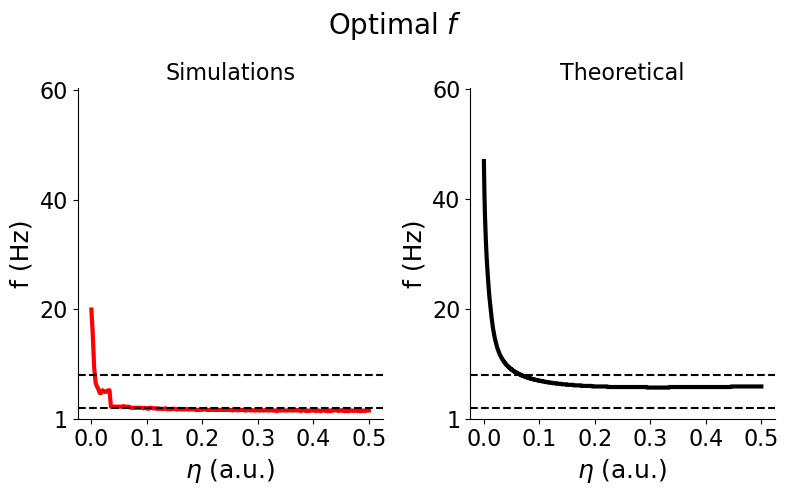

In [74]:
plt.figure(figsize=(8,5))

plt.suptitle('Optimal $f$', fontsize=20)

plt.subplot(121)
res = 200
plt.plot(optimal_fs_sim*(res/100), linewidth=3, color='r', alpha=1, label='sim')
plt.title('Simulations', fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).astype(int), fontsize=16)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(0.0001, 0.5, 6).round(3), fontsize=16)
plt.ylabel('f (Hz)', fontsize=18)
plt.xlabel('$\eta$ (a.u.)', fontsize=18)

plt.axhline(2*(res/100), color='k', linestyle='--')
plt.axhline(8*(res/100), color='k', linestyle='--')

plt.ylim(0,60*(res/100))
sb.despine()


plt.subplot(122)
res = 1000
plt.plot(optimal_fs_theo*(res/100), linewidth=3, color='k', alpha=1, label='theo')
plt.title('Theoretical', fontsize=16)
plt.yticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).astype(int), fontsize=16)
plt.xticks(np.linspace(0, res-1, 6), np.linspace(0.0001, 0.5, 6).round(3), fontsize=16)
plt.ylabel('f (Hz)', fontsize=18)
plt.xlabel('$\eta$ (a.u.)', fontsize=18)

plt.axhline(2*(res/100), color='k', linestyle='--')
plt.axhline(8*(res/100), color='k', linestyle='--')

plt.ylim(0,60*(res/100))
sb.despine()

#plt.legend(title='$τ$_in', fontsize=12, title_fontsize='large', frameon=False)

plt.tight_layout()
#plt.savefig('plots/optimal_f.png', dpi=600)
plt.show()

## Population code

In [49]:
# Params
R_m = 142 * 1e6        # MOmh
V_th = 15 * 1e-3       # mV
tau_m = 24 * 1e-3      # ms
eta = 0.11
v_osc_amp = 5 * 1e-3   # mV
M = 10                 # number input levels
range_frac = 0.75

In [50]:
M = 10
res = 1000
fs = np.linspace(1, 100, res)
Ns = np.linspace(1, 1000, res)
mis = np.zeros((res,res))
for i, N in enumerate(Ns):
    print(i)
    for j, f in enumerate(fs):
        means, variances, Is_range = get_distr(R_m, V_th, eta, tau_m, v_osc_amp, f, M, range_frac, N)
        mis[i,j] = approx_mi(means, variances)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [51]:
info_rate_Ns = get_R(mis, fs, tau_x=200e-3, norm=True)

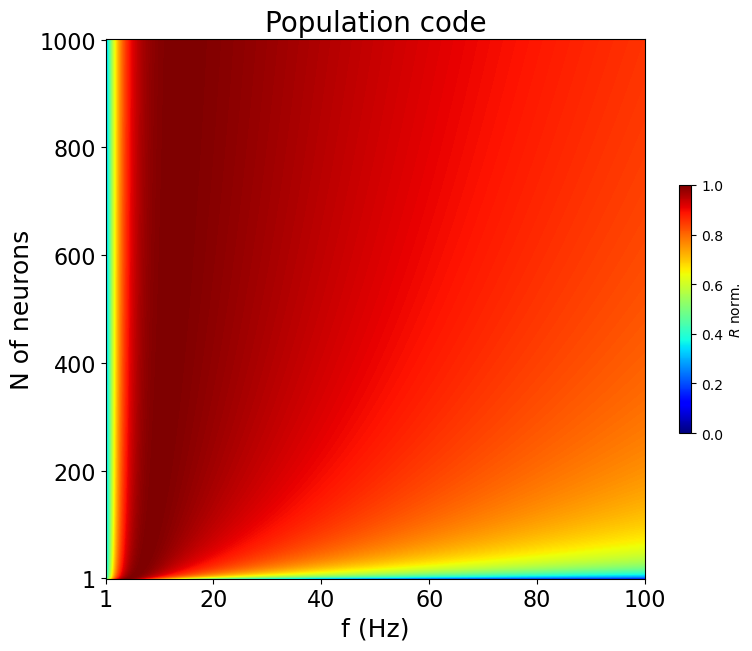

In [52]:
plt.figure(figsize=(8,7))

plt.title('Population code', fontsize=20)
plt.imshow(info_rate_Ns, origin='lower', cmap='jet', vmin=0)
plt.xticks(np.linspace(0, res-1, 6).astype(int), np.linspace(1, 100, 6).astype(int), fontsize=16)
plt.yticks(np.linspace(0, res-1, 6).astype(int), np.linspace(1, 1000, 6).astype(int), fontsize=16)
plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('N of neurons', fontsize=18)
plt.colorbar(label='$R$ norm.', shrink=.4)

plt.tight_layout()
plt.savefig('plots/pop_code.png', dpi=600)
plt.show()

In [53]:
optimal_fs_ = []
tau_x_range = np.array([200, 100, 50, 25])*1e-3
for tau_x_ in tau_x_range:
    info_rate_Ns_ = get_R(mis, fs, tau_x_, norm=True)
    optimal_fs_.append(fs[np.argmax(info_rate_Ns_, axis=1)])

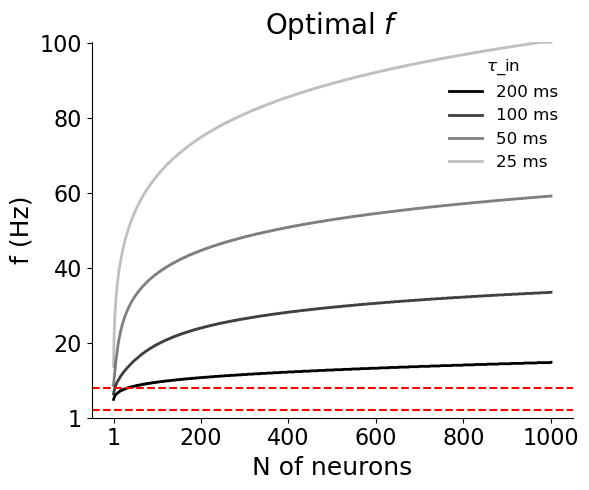

In [54]:
plt.figure(figsize=(6,5))

plt.title('Optimal $f$', fontsize=20)

for i, tau_x_ in enumerate(tau_x_range):
    plt.plot(optimal_fs_[i]*(res/100), linewidth=2, color='k', alpha=1-(2.5*i/10), label=str(int(tau_x_*1e3))+' ms')

plt.yticks(np.linspace(0, res-1, 6), np.linspace(1, 100, 6).astype(int), fontsize=16)
plt.xticks(np.linspace(0, res-1, 6).astype(int), np.linspace(1, 1000, 6).astype(int), fontsize=16)
plt.ylabel('f (Hz)', fontsize=18)
plt.xlabel('N of neurons', fontsize=18)

plt.axhline(20, color='r', linestyle='--')
plt.axhline(80, color='r', linestyle='--')

plt.ylim(0,1000)

plt.legend(title='$τ$_in', fontsize=12, title_fontsize='large', frameon=False)

plt.tight_layout()
sb.despine()
plt.savefig('plots/optimal_f_Nneurons.png', dpi=600)
plt.show()

## Frequency analysis

In [55]:
def cutoff_frequency(tau_m):
    '''
    Frequency where the power falls to 1/2 (or the amplitude falls to 1/sqrt(2)) of the maximum 
    '''
    return 1 / (2 * np.pi * tau_m)


def amplitude_mem_potential(R_m, I_osc, tau_m, f):
    A = 1 / np.sqrt(1 + (tau_m * 2 * np.pi * f)**2)
    amplitude = R_m * I_osc * A
    return amplitude

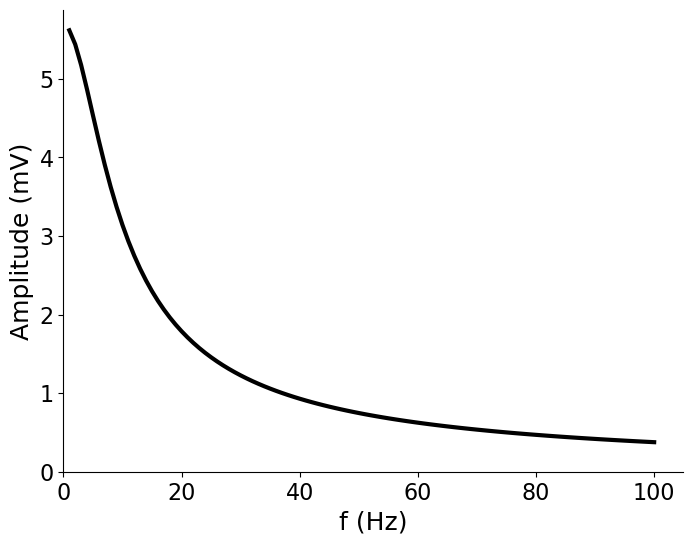

In [56]:
fs = np.linspace(1,100,100)
amp = amplitude_mem_potential(R_m, I_osc, tau_m, fs)

plt.figure(figsize=(8,6))

plt.plot(fs, amp*1e3, color='k', linewidth=3)

#plt.hlines(y=1/np.sqrt(2), xmin=0, xmax=cutoff_frequency(tau_m), linestyle='--', color='r', linewidth=1)

plt.xlabel('f (Hz)', fontsize=18)
plt.ylabel('Amplitude (mV)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0)
plt.xlim(0)

sb.despine()
#plt.savefig('amp.png', dpi=600)
plt.show()

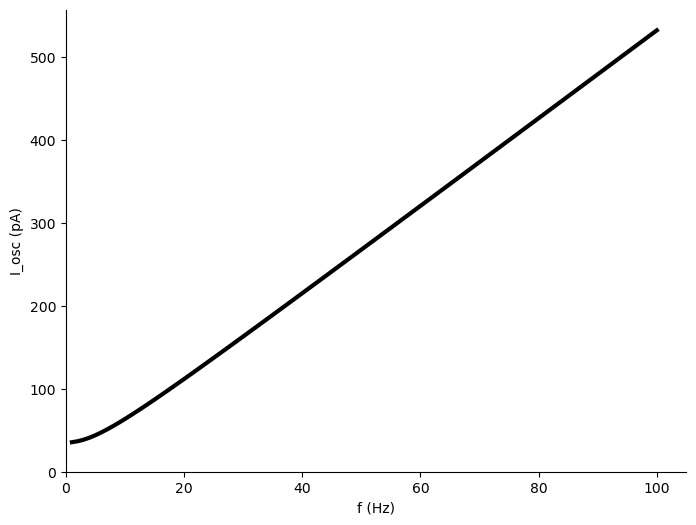

In [179]:
fs = np.linspace(1,100,100)
v_osc_amp = 5 * 1e-3   # mV

I_oscs = compute_Iosc(v_osc_amp, R_m, tau_m, fs)

plt.figure(figsize=(8,6))

plt.plot(fs, I_oscs*1e12, color='k', linewidth=3)

plt.xlabel('f (Hz)')
plt.ylabel('I_osc (pA)')
plt.ylim(0)
plt.xlim(0)

sb.despine()
plt.show()